In [1]:
import argparse
import pickle

import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Convolutional encoder
        self.conv1 = nn.Conv2d(1, 6, 5)  # 1 input channel, 6 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5x5 kernel

        # Fully connected layers / Dense block
        self.fc1 = nn.Linear(16 * 4 * 4, 120) # 256 * 120
        self.fc2 = nn.Linear(120, 84)         # 120 inputs, 84 outputs
        self.fc3 = nn.Linear(84, 10)          # 84 inputs, 10 outputs (number of classes)

    def forward(self, x):
        # Convolutional block
        x = F.avg_pool2d(F.sigmoid(self.conv1(x)), (2, 2)) # Convolution -> Sigmoid -> Avg Pool
        x = F.avg_pool2d(F.sigmoid(self.conv2(x)), (2, 2)) # Convolution -> Sigmoid -> Avg Pool

        # Flattening
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)  # No activation function here, will use CrossEntropyLoss later
        return x

In [3]:
class LeNet_(nn.Module):
    def __init__(self, features=(6, 16, 120, 84)):
        super(LeNet, self).__init__()

        features = list(features)
        if len(features) == 3:
            features.append(None)

        f1, f2, f3, f4 = features

        self.conv1 = nn.Conv2d(1, f1, kernel_size=5)
        self.conv2 = nn.Conv2d(f1, f2, kernel_size=5)
        self.fc1 = nn.Linear(f2 * 4 * 4, f3)
        if f4 is not None:
            self.fc2 = nn.Linear(f3, f4)
            self.fc3 = nn.Linear(f4, 10)
        else:
            self.fc2 = nn.Linear(f3, 10)
            self.fc3 = None

    def forward(self, x):
        # Note that tanh activation does a better job at keeping activations in a predictable
        # range. This means that fewer bits are needed for quantization!
        x = torch.tanh(self.conv1(x))
        x = torch.nn.functional.avg_pool2d(x, 2)
        x = torch.tanh(self.conv2(x))
        x = torch.nn.functional.avg_pool2d(x, 2)
        x = x.flatten(1)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        if self.fc3 is not None:
            x = self.fc3(torch.tanh(x))
        return x

In [36]:
from torchvision.transforms import ToTensor
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def load_dataset(batch_size=256):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, transform=ToTensor(), download=True)
    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, transform=ToTensor())

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_dataset, test_dataset


def train(model, train_dataset, learning_rate=0.001, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()  # Set the model to training mode

    # Train the model
    for epoch in range(num_epochs):
        total_loss = 0
        # Wrap the train_dataset with tqdm for a progress bar
        for images, labels in tqdm(train_dataset, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Print average loss for the epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {total_loss / len(train_dataset):.4f}')


def evaluate(model, test_dataset):
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for images, labels in test_dataset:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Test Accuracy: {accuracy:.2f}%')


In [94]:
img = test_dataset[10][0]
img = img.unsqueeze(0)  # Add a batch dimension
images = img.to(device)

outputs = model(images)

print (outputs)

tensor([[ 7.8762, -5.5624,  1.3357, -1.6389, -3.0630,  1.1249,  0.0394, -1.9192,
         -2.3672, -2.1795]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [49]:
import matplotlib.pyplot as plt

def plot_mnist_images(dataset, indices = []):

    if not indices:
        fig, axes = plt.subplots(1, len(dataset), figsize=(12, 4))
        
        for i in range(len(axes)):
            image, label = dataset[i]
            ax = axes[i]
            
            image = image.squeeze()  # Remove channel dimension

            ax.imshow(image, cmap='gray')
            ax.set_title(f'Label: {label}')
            ax.axis('off')

        plt.show()
        return

    fig, axes = plt.subplots(1, len(indices), figsize=(12, 4))
    if len(indices) == 1:  # If only one index is provided, wrap axes in a list
        axes = [axes]
    
    for ax, idx in zip(axes, indices):
        image, label = dataset[idx]
        image = image.squeeze()  # Remove channel dimension

        ax.imshow(image, cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')

    plt.show()


In [38]:
# Load the dataset
train_loader, test_loader, train_dataset, test_dataset = load_dataset()

In [39]:
# Train the model (in a separate cell)
model = LeNet().to(device)
train(model, train_loader)

Epoch 1/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/10: 100%|██████████| 235/235 [00:01<00:00, 139.98it/s]


Epoch [1/10], Average Loss: 2.0845


Epoch 2/10: 100%|██████████| 235/235 [00:01<00:00, 146.34it/s]


Epoch [2/10], Average Loss: 0.6778


Epoch 3/10: 100%|██████████| 235/235 [00:01<00:00, 149.67it/s]


Epoch [3/10], Average Loss: 0.3671


Epoch 4/10: 100%|██████████| 235/235 [00:01<00:00, 149.81it/s]


Epoch [4/10], Average Loss: 0.2793


Epoch 5/10: 100%|██████████| 235/235 [00:01<00:00, 149.97it/s]


Epoch [5/10], Average Loss: 0.2278


Epoch 6/10: 100%|██████████| 235/235 [00:01<00:00, 149.61it/s]


Epoch [6/10], Average Loss: 0.1937


Epoch 7/10: 100%|██████████| 235/235 [00:01<00:00, 150.37it/s]


Epoch [7/10], Average Loss: 0.1675


Epoch 8/10: 100%|██████████| 235/235 [00:01<00:00, 150.05it/s]


Epoch [8/10], Average Loss: 0.1485


Epoch 9/10: 100%|██████████| 235/235 [00:01<00:00, 149.29it/s]


Epoch [9/10], Average Loss: 0.1335


Epoch 10/10: 100%|██████████| 235/235 [00:01<00:00, 150.39it/s]

Epoch [10/10], Average Loss: 0.1213


In [40]:
evaluate(model, test_loader)

Test Accuracy: 96.51%


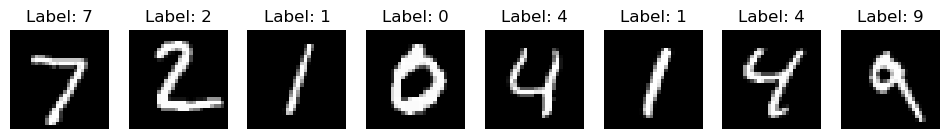

In [56]:
plot_mnist_images(test_dataset, [0,1,2,3,4,5,6,7])

In [75]:
import ezkl, os, json

run_args = ezkl.PyRunArgs()
run_args.input_visibility = "public"
run_args.param_visibility = "fixed"
run_args.output_visibility = "public"
# run_args.num_inner_cols = 2
run_args.variables = [("batch_size", 0)]

# Capture set of data points
num_data_points = 8

# Fetch data points from the train_dataset
data_points = []
for i, (data_point, _) in enumerate(test_loader):
    if i >= num_data_points:
        break
    data_points.append(data_point)


In [16]:
torch.stack(data_points).dim()

5

In [149]:
def gen_witness_LN(folder, model, data_point):
    model_path = os.path.join(folder, 'network.onnx')
    compiled_model_path = os.path.join(folder, 'network.compiled')
    settings_path = os.path.join(folder, 'settings.json') 
    witness_path = os.path.join(folder, 'witness.json')
    data_path = os.path.join(folder, 'input.json')

    # cal_path = os.path.join(folder, "cal_data.json")
    # srs_path = os.path.join(folder, 'kzg.srs')

    model.eval()
    # Verify the device (CPU or CUDA) and transfer the data point to the same device as the model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    data_point = data_point.to(device).unsqueeze(0)  # Add a batch dimension
    # _, pred = torch.max(model(data_point),1)
    # train_data_point = train_data_point.to(device)
    # # Export the model to ONNX format
    torch.onnx.export(model, 
                      data_point, 
                      model_path, 
                      export_params=True, 
                      opset_version=10, 
                      do_constant_folding=True, 
                      input_names=['input_0'], 
                      output_names=['output'])

    # Convert the tensor to numpy array and reshape it for JSON serialization
    x = (data_point.cpu().detach().numpy().reshape([-1])).tolist()
    data = dict(input_data = [x])

    # Serialize data into file:
    json.dump(data, open(data_path, 'w'))

    # data_points = []
    # for i, (data_point, _) in enumerate(dataset):
    #     if i >= num_data_points:
    #         break
    #     data_points.append(data_point)
        
    # # plot_mnist_images(data_points)

    # # Stack the data points to create a batch
    # train_data_batch = torch.stack(data_points)

    # # Add a batch dimension if not already present
    # if train_data_batch.dim() == 3: # dim == 5
    #     train_data_batch = train_data_batch.unsqueeze(0)

    # x = train_data_batch.cpu().detach().numpy().reshape([-1]).tolist()

    # data = dict(input_data = [x])

    # cal_path = os.path.join('cal_data.json')

    # # Serialize data into file:
    # json.dump( data, open(cal_path, 'w' ))
    os.environ['RUST_LOG'] = 'none'
    res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
    assert res == True

    res = ezkl.calibrate_settings(data_path, model_path, settings_path, "resources", scales=[2,7])
    assert res == True

    res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
    assert res == True

    # srs path
    res = ezkl.get_srs(settings_path)

    # now generate the witness file
    res = ezkl.gen_witness(data_path, compiled_model_path, witness_path)
    assert os.path.isfile(witness_path)

    with open(witness_path, "r") as f:
        wit = json.load(f)

    with open(settings_path, "r") as f:
        setting = json.load(f)

    prediction_array = []
    for value in wit["outputs"]:
        for field_element in value:
            prediction_array.append(ezkl.vecu64_to_float(field_element, setting['model_output_scales'][0]))
    return torch.argmax(torch.Tensor([prediction_array]), dim=1)
    #print ('Prediction:', torch.argmax(torch.Tensor([prediction_array]), dim=1) == label.cpu())

In [150]:
def computer_accuracy(folder, model, dataset, size):
    total = 0
    correct = 0

    # folder = "./tmp/"
    # Create the directory 'tmp' in the current working directory
    try:
        os.makedirs(folder, exist_ok=True)
        print(f"Directory '{folder}' created successfully")
    except OSError as error:
        print(f"Directory '{folder}' cannot be created. Error: {error}")

    for image, _ in dataset:
        pred_quantized = gen_witness_LN(folder, model, image)
        outputs = model(image.unsqueeze(0).to(device))
        pred = torch.argmax(outputs, 1)

        total += 1
        correct += (pred == pred_quantized.to(device))

        if total > size:
            break
    
    return 100*correct/total
    #print (f'Test Accuracy: {accuracy:.2f}% (quantized)')

In [154]:
!export RUST_LOG=none
computer_accuracy('./tmp/', model, test_dataset,10)

Directory './tmp/' created successfully


max lookup input (5840084219) is too large
max lookup input (188294704396) is too large




 <------------- Numerical Fidelity Report (input_scale: 2, param_scale: 2, scale_input_multiplier: 10) ------------->

+------------+--------------+-----------+------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error | median_error | max_error | min_error  | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+------------+--------------+-----------+------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| 0.10877423 | -0.6346321   | 1.1195042 | -0.6346321 | 0.52467203     | 0.6346321        | 1.1195042     | 0.023257136   | 0.39918754         | -0.042917054       | 0.29733515             |
+------------+--------------+-----------+------------+----------------+------------------+---------------+-------------

max lookup input (7123415395) is too large
max lookup input (228817077529) is too large




 <------------- Numerical Fidelity Report (input_scale: 2, param_scale: 2, scale_input_multiplier: 10) ------------->

+------------+--------------+------------+-------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error | median_error | max_error  | min_error   | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+------------+--------------+------------+-------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| 0.13927169 | 0.46184516   | 0.85216045 | -0.76268077 | 0.46523127     | 0.46184516       | 0.85216045    | 0.019587636   | 0.2904287          | 0.5841441          | 0.71635526             |
+------------+--------------+------------+-------------+----------------+------------------+---------------+---

max lookup input (5097476635) is too large
max lookup input (163934125686) is too large




 <------------- Numerical Fidelity Report (input_scale: 2, param_scale: 2, scale_input_multiplier: 10) ------------->

+------------+--------------+-----------+------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error | median_error | max_error | min_error  | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+------------+--------------+-----------+------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| 0.19726206 | 0.12251371   | 3.6286678 | -2.2733622 | 1.3715818      | 0.12251371       | 3.6286678     | 0.038722992   | 2.8920581          | 0.32737696         | 1.1770984              |
+------------+--------------+-----------+------------+----------------+------------------+---------------+-------------

max lookup input (4657653313) is too large
max lookup input (148958747263) is too large




 <------------- Numerical Fidelity Report (input_scale: 2, param_scale: 2, scale_input_multiplier: 10) ------------->

+------------+--------------+-----------+------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error | median_error | max_error | min_error  | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+------------+--------------+-----------+------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| 0.10827174 | -0.18369207  | 0.6876557 | -0.3114463 | 0.25277203     | 0.18369207       | 0.6876557     | 0.01960659    | 0.1115577          | -4.132343          | 4.464719               |
+------------+--------------+-----------+------------+----------------+------------------+---------------+-------------

max lookup input (4536173200) is too large
max lookup input (145086172736) is too large




 <------------- Numerical Fidelity Report (input_scale: 2, param_scale: 2, scale_input_multiplier: 10) ------------->

+------------+--------------+-----------+------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error | median_error | max_error | min_error  | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+------------+--------------+-----------+------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| 0.10749078 | 0.78533196   | 1.5869818 | -0.8834803 | 0.5445302      | 0.78533196       | 1.5869818     | 0.033890486   | 0.5202986          | -0.027773285       | 0.24474008             |
+------------+--------------+-----------+------------+----------------+------------------+---------------+-------------

max lookup input (5537852148) is too large
max lookup input (177399734352) is too large




 <------------- Numerical Fidelity Report (input_scale: 2, param_scale: 2, scale_input_multiplier: 10) ------------->

+------------+--------------+-----------+------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error | median_error | max_error | min_error  | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+------------+--------------+-----------+------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| 0.1619865  | 0.12481117   | 2.8409224 | -1.7739587 | 1.0733268      | 0.12481117       | 2.8409224     | 0.12481117    | 1.7046063          | -10.873143         | 11.747632              |
+------------+--------------+-----------+------------+----------------+------------------+---------------+-------------

max lookup input (5121962597) is too large
max lookup input (164048651694) is too large




 <------------- Numerical Fidelity Report (input_scale: 2, param_scale: 2, scale_input_multiplier: 10) ------------->

+------------+--------------+-----------+-----------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error | median_error | max_error | min_error | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+------------+--------------+-----------+-----------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| 0.14417407 | -0.18072757  | 1.7239714 | -1.23248  | 0.7714158      | 0.18072757       | 1.7239714     | 0.05796051    | 0.9272524          | -37.3002           | 37.82839               |
+------------+--------------+-----------+-----------+----------------+------------------+---------------+---------------+--

max lookup input (5373959264) is too large
max lookup input (171602823559) is too large




 <------------- Numerical Fidelity Report (input_scale: 2, param_scale: 2, scale_input_multiplier: 10) ------------->

+------------+--------------+-----------+------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error | median_error | max_error | min_error  | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+------------+--------------+-----------+------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| 0.21250205 | -0.33878827  | 1.8112109 | -0.8577714 | 0.8203079      | 0.33878827       | 1.8112109     | 0.2651112     | 0.9485863          | 0.31185788         | 0.562792               |
+------------+--------------+-----------+------------+----------------+------------------+---------------+-------------

max lookup input (3810449903) is too large
max lookup input (122713178545) is too large




 <------------- Numerical Fidelity Report (input_scale: 2, param_scale: 2, scale_input_multiplier: 10) ------------->

+------------+--------------+-----------+-------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error | median_error | max_error | min_error   | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+------------+--------------+-----------+-------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| 0.14790545 | 0.77310705   | 1.4100486 | -0.75581884 | 0.6163294      | 0.77310705       | 1.4100486     | 0.19611356    | 0.48435888         | 0.96927834         | 1.3165138              |
+------------+--------------+-----------+-------------+----------------+------------------+---------------+--------

max lookup input (5660700129) is too large
max lookup input (182202950372) is too large




 <------------- Numerical Fidelity Report (input_scale: 2, param_scale: 2, scale_input_multiplier: 10) ------------->

+------------+--------------+-----------+------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error | median_error | max_error | min_error  | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+------------+--------------+-----------+------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| 0.1140404  | -0.25782943  | 1.2227402 | -0.8524755 | 0.57307005     | 0.25782943       | 1.2227402     | 0.109627426   | 0.4734214          | -0.48157567        | 0.9180894              |
+------------+--------------+-----------+------------+----------------+------------------+---------------+-------------

max lookup input (6006407662) is too large
max lookup input (191890152892) is too large




 <------------- Numerical Fidelity Report (input_scale: 2, param_scale: 2, scale_input_multiplier: 10) ------------->

+------------+--------------+-----------+-------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error | median_error | max_error | min_error   | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+------------+--------------+-----------+-------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| 0.10041976 | 0.15360844   | 0.4544456 | -0.12183809 | 0.14487748     | 0.15360844       | 0.4544456     | 0.013891697   | 0.03595019         | 0.5776064          | 0.6177334              |
+------------+--------------+-----------+-------------+----------------+------------------+---------------+--------

tensor([100.], device='cuda:0')

In [148]:
acc

tensor([100.], device='cuda:0')

In [33]:
def verify_LN_proof():
    compiled_model_path = os.path.join(folder, 'network.compiled')
    settings_path = os.path.join(folder, 'settings.json') 
    witness_path = os.path.join(folder, 'witness.json')
    proof_path = os.path.join(folder, 'proof.json')
    srs_path = os.path.join(folder, 'kzg.srs')

    pk_path = os.path.join(folder, 'test.pk')
    vk_path = os.path.join(folder, 'test.vk')


    res = ezkl.mock(witness_path, compiled_model_path)
    assert res == True

    res = ezkl.setup(
            compiled_model_path,
            vk_path,
            pk_path,
        )


    assert res == True
    assert os.path.isfile(vk_path)
    assert os.path.isfile(pk_path)
    assert os.path.isfile(settings_path)

    # Generate the proof
    proof = ezkl.prove(
            witness_path,
            compiled_model_path,
            pk_path,
            proof_path,
            "single",
        )
    print(proof)
    assert os.path.isfile(proof_path)

    # verify our proof
    res = ezkl.verify(
            proof_path,
            settings_path,
            vk_path,
        )

    assert res == True
    print("verified")

In [34]:
verify_LN_proof()

spawning module 2
spawning module 2
spawning module 2
spawning module 2


{'instances': [[[10799958826997019694, 13732764088618192092, 9080164469342476020, 2707268858854354691], [14424721036421401993, 1925070949615222816, 15662063748651391231, 2658040235317113047], [1215616954971237343, 12781145858640582370, 3205897164118176512, 2866280021565530741], [16586418689708852361, 7719159825332846314, 11409209055533372999, 2915207530297009380], [6517656510695314680, 15914426195874827226, 4307566795511864752, 3240703511491837769], [4164547517116989137, 10669376283223625029, 6844937459063939938, 3458232284123655186], [10397520845017782036, 13129438026871282772, 16302847471085186583, 1825458023941667617], [6523463390768162622, 11459244905309910398, 17257037644834070972, 1430799349594821442], [13327914677011761971, 3991458216124611539, 4353392374763218262, 501949994929955151], [11035042354946947612, 2049718776522464053, 8894110146517096806, 3168295732512543866]]], 'proof': '0x0f5a31a4da4bf2e1469d40700f891adc23f25e693e81ef7953871de814f8ef211818e449ce59f0f2f9c60aa8d6d376e